# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 20/05/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-05-31 21:09:14.092665: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 21:09:14.124778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 21:09:15.420296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 21:09:15.424177: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Dataset

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-05-31 21:09:16.141459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


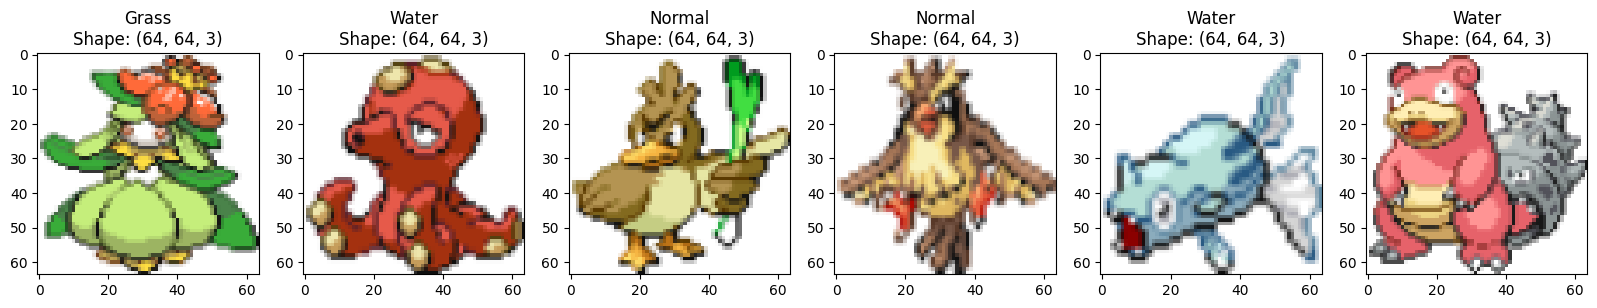

2024-05-31 21:09:17.118181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# wasserstein_loss = WassersteinLoss()

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

## 2.1. Training

Epoch 1/500


I0000 00:00:1717189769.608401   87376 service.cc:145] XLA service 0x71377c003ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717189769.608434   87376 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-31 21:09:29.978079: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1717189770.486359   87376 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-05-31 21:09:31.364379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1717189773.194472   87763 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 8 bytes sp

  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:12:17 34s/step - accuracy: 0.3500 - loss: 2.0491

I0000 00:00:1717189792.545589   87376 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.5770 - loss: 0.7885
Epoch 2/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.8263 - loss: 0.2498
Epoch 3/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.8601 - loss: 0.1788
Epoch 4/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.8777 - loss: 0.1507
Epoch 5/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.8882 - loss: 0.1339
Epoch 6/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.8959 - loss: 0.1224
Epoch 7/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.8970 - loss: 0.1235
Epoch 8/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9046 - loss: 0.1116
Epoch 9/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9068 - loss: 0.1102
Epoch 10/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9104 - loss: 0.1047
Epoch 11/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9117 - loss: 0.1041
Epoch 12/500
127/127

Sampling sprite...: 100%|██████████| 1000/1000 [01:30<00:00, 11.07it/s]


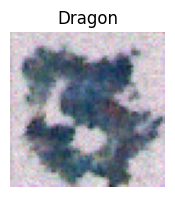

127/127 ━━━━━━━━━━━━━━━━━━━━ 110s 875ms/step - accuracy: 0.9225 - loss: 0.0939
Epoch 21/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9220 - loss: 0.0956
Epoch 22/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9251 - loss: 0.0899
Epoch 23/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9232 - loss: 0.0939
Epoch 24/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9247 - loss: 0.0915
Epoch 25/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9262 - loss: 0.0892
Epoch 26/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9271 - loss: 0.0888
Epoch 27/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9270 - loss: 0.0888
Epoch 28/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9282 - loss: 0.0867
Epoch 29/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9257 - loss: 0.0925
Epoch 30/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9286 - loss: 0.0865
Epoch 31/50

Sampling sprite...: 100%|██████████| 1000/1000 [01:29<00:00, 11.17it/s]


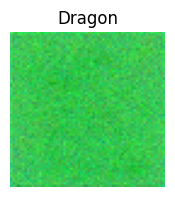

127/127 ━━━━━━━━━━━━━━━━━━━━ 110s 868ms/step - accuracy: 0.9330 - loss: 0.0826
Epoch 41/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9332 - loss: 0.0818
Epoch 42/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9341 - loss: 0.0807
Epoch 43/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9323 - loss: 0.0844
Epoch 44/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9360 - loss: 0.0765
Epoch 45/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9341 - loss: 0.0815
Epoch 46/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9349 - loss: 0.0796
Epoch 47/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9352 - loss: 0.0794
Epoch 48/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9353 - loss: 0.0794
Epoch 49/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9354 - loss: 0.0791
Epoch 50/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9348 - loss: 0.0799
Epoch 51/50

Sampling sprite...: 100%|██████████| 1000/1000 [01:29<00:00, 11.19it/s]


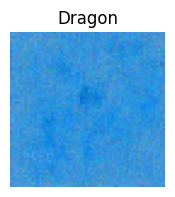

127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 867ms/step - accuracy: 0.9387 - loss: 0.0753
Epoch 61/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9372 - loss: 0.0774
Epoch 62/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9371 - loss: 0.0777
Epoch 63/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9369 - loss: 0.0785
Epoch 64/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9387 - loss: 0.0747
Epoch 65/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9382 - loss: 0.0769
Epoch 66/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9388 - loss: 0.0756
Epoch 67/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9372 - loss: 0.0785
Epoch 68/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9376 - loss: 0.0782
Epoch 69/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9400 - loss: 0.0737
Epoch 70/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9377 - loss: 0.0785
Epoch 71/50

Sampling sprite...: 100%|██████████| 1000/1000 [01:29<00:00, 11.12it/s]


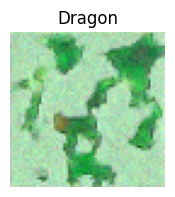

127/127 ━━━━━━━━━━━━━━━━━━━━ 110s 872ms/step - accuracy: 0.9403 - loss: 0.0735
Epoch 81/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9410 - loss: 0.0724
Epoch 82/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9412 - loss: 0.0722
Epoch 83/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9396 - loss: 0.0752
Epoch 84/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9392 - loss: 0.0757
Epoch 85/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9398 - loss: 0.0748
Epoch 86/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9405 - loss: 0.0737
Epoch 87/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9418 - loss: 0.0710
Epoch 88/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9410 - loss: 0.0732
Epoch 89/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9402 - loss: 0.0744
Epoch 90/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9402 - loss: 0.0736
Epoch 91/50

Sampling sprite...: 100%|██████████| 1000/1000 [01:33<00:00, 10.67it/s]


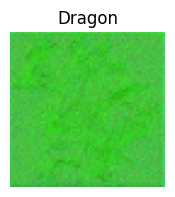

127/127 ━━━━━━━━━━━━━━━━━━━━ 114s 901ms/step - accuracy: 0.9419 - loss: 0.0721
Epoch 101/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9428 - loss: 0.0697
Epoch 102/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9405 - loss: 0.0747
Epoch 103/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9426 - loss: 0.0709
Epoch 104/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9428 - loss: 0.0706
Epoch 105/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9437 - loss: 0.0687
Epoch 106/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9428 - loss: 0.0704
Epoch 107/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9420 - loss: 0.0720
Epoch 108/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9438 - loss: 0.0695
Epoch 109/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9435 - loss: 0.0695
Epoch 110/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9430 - loss: 0.0705
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:30<00:00, 11.03it/s]


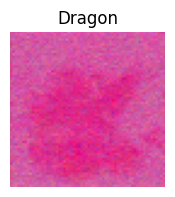

127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 876ms/step - accuracy: 0.9438 - loss: 0.0691
Epoch 121/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9437 - loss: 0.0705
Epoch 122/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9463 - loss: 0.0648
Epoch 123/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9436 - loss: 0.0695
Epoch 124/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9442 - loss: 0.0694
Epoch 125/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9451 - loss: 0.0672
Epoch 126/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9422 - loss: 0.0725
Epoch 127/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9444 - loss: 0.0686
Epoch 128/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9451 - loss: 0.0672
Epoch 129/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9455 - loss: 0.0675
Epoch 130/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9459 - loss: 0.0665
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]


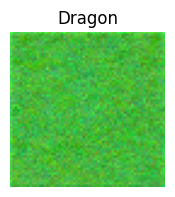

127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 862ms/step - accuracy: 0.9456 - loss: 0.0677
Epoch 141/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9451 - loss: 0.0685
Epoch 142/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9448 - loss: 0.0692
Epoch 143/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9457 - loss: 0.0665
Epoch 144/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9457 - loss: 0.0663
Epoch 145/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9450 - loss: 0.0689
Epoch 146/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9447 - loss: 0.0684
Epoch 147/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9426 - loss: 0.0726
Epoch 148/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9450 - loss: 0.0686
Epoch 149/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9452 - loss: 0.0672
Epoch 150/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9468 - loss: 0.0648
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:29<00:00, 11.18it/s]


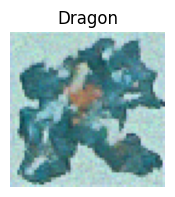

127/127 ━━━━━━━━━━━━━━━━━━━━ 110s 868ms/step - accuracy: 0.9471 - loss: 0.0657
Epoch 161/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9450 - loss: 0.0688
Epoch 162/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9468 - loss: 0.0656
Epoch 163/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9462 - loss: 0.0657
Epoch 164/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9468 - loss: 0.0658
Epoch 165/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9454 - loss: 0.0681
Epoch 166/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9468 - loss: 0.0667
Epoch 167/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9468 - loss: 0.0654
Epoch 168/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9482 - loss: 0.0637
Epoch 169/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9454 - loss: 0.0692
Epoch 170/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9468 - loss: 0.0661
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:30<00:00, 11.08it/s]


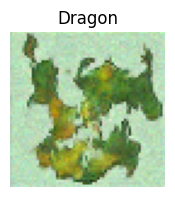

127/127 ━━━━━━━━━━━━━━━━━━━━ 110s 875ms/step - accuracy: 0.9480 - loss: 0.0645
Epoch 181/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9462 - loss: 0.0670
Epoch 182/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9463 - loss: 0.0665
Epoch 183/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9474 - loss: 0.0661
Epoch 184/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9480 - loss: 0.0641
Epoch 185/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9470 - loss: 0.0658
Epoch 186/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9470 - loss: 0.0661
Epoch 187/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9477 - loss: 0.0647
Epoch 188/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9490 - loss: 0.0630
Epoch 189/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9483 - loss: 0.0641
Epoch 190/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9473 - loss: 0.0646
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:28<00:00, 11.29it/s]


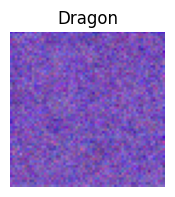

127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 861ms/step - accuracy: 0.9483 - loss: 0.0645
Epoch 201/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9488 - loss: 0.0630
Epoch 202/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9468 - loss: 0.0669
Epoch 203/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9481 - loss: 0.0648
Epoch 204/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9490 - loss: 0.0628
Epoch 205/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9489 - loss: 0.0633
Epoch 206/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9484 - loss: 0.0640
Epoch 207/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9493 - loss: 0.0624
Epoch 208/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9494 - loss: 0.0628
Epoch 209/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9478 - loss: 0.0648
Epoch 210/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9500 - loss: 0.0612
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]


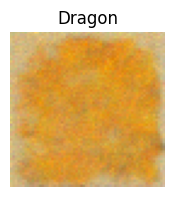

127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 858ms/step - accuracy: 0.9475 - loss: 0.0655
Epoch 221/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9489 - loss: 0.0632
Epoch 222/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9493 - loss: 0.0618
Epoch 223/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9470 - loss: 0.0677
Epoch 224/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9472 - loss: 0.0672
Epoch 225/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9499 - loss: 0.0619
Epoch 226/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9496 - loss: 0.0625
Epoch 227/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9487 - loss: 0.0643
Epoch 228/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9494 - loss: 0.0626
Epoch 229/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9507 - loss: 0.0612
Epoch 230/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9500 - loss: 0.0626
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:27<00:00, 11.46it/s]


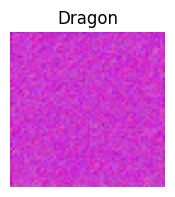

127/127 ━━━━━━━━━━━━━━━━━━━━ 107s 850ms/step - accuracy: 0.9514 - loss: 0.0608
Epoch 241/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9480 - loss: 0.0655
Epoch 242/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9487 - loss: 0.0652
Epoch 243/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9497 - loss: 0.0637
Epoch 244/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9492 - loss: 0.0632
Epoch 245/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9504 - loss: 0.0617
Epoch 246/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9505 - loss: 0.0618
Epoch 247/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9503 - loss: 0.0621
Epoch 248/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9473 - loss: 0.0657
Epoch 249/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9500 - loss: 0.0629
Epoch 250/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9513 - loss: 0.0602
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:28<00:00, 11.35it/s]


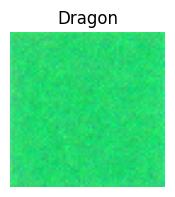

127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 857ms/step - accuracy: 0.9510 - loss: 0.0611
Epoch 261/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9499 - loss: 0.0628
Epoch 262/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9508 - loss: 0.0615
Epoch 263/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9505 - loss: 0.0626
Epoch 264/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9504 - loss: 0.0618
Epoch 265/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9499 - loss: 0.0637
Epoch 266/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9493 - loss: 0.0634
Epoch 267/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9503 - loss: 0.0630
Epoch 268/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9500 - loss: 0.0635
Epoch 269/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9507 - loss: 0.0617
Epoch 270/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9497 - loss: 0.0636
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:28<00:00, 11.26it/s]


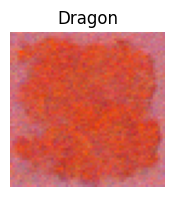

127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 862ms/step - accuracy: 0.9485 - loss: 0.0647
Epoch 281/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9512 - loss: 0.0611
Epoch 282/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9491 - loss: 0.0646
Epoch 283/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9513 - loss: 0.0617
Epoch 284/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9498 - loss: 0.0645
Epoch 285/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9498 - loss: 0.0635
Epoch 286/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9519 - loss: 0.0606
Epoch 287/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9506 - loss: 0.0632
Epoch 288/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9495 - loss: 0.0642
Epoch 289/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9536 - loss: 0.0574
Epoch 290/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9502 - loss: 0.0627
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:29<00:00, 11.19it/s]


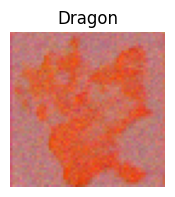

127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 867ms/step - accuracy: 0.9515 - loss: 0.0613
Epoch 301/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9522 - loss: 0.0590
Epoch 302/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9515 - loss: 0.0606
Epoch 303/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9525 - loss: 0.0594
Epoch 304/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9513 - loss: 0.0620
Epoch 305/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9517 - loss: 0.0613
Epoch 306/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9514 - loss: 0.0617
Epoch 307/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9510 - loss: 0.0625
Epoch 308/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9517 - loss: 0.0608
Epoch 309/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9515 - loss: 0.0605
Epoch 310/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9503 - loss: 0.0628
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:28<00:00, 11.26it/s]


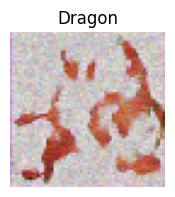

127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 863ms/step - accuracy: 0.9521 - loss: 0.0600
Epoch 321/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9535 - loss: 0.0578
Epoch 322/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9522 - loss: 0.0600
Epoch 323/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9506 - loss: 0.0634
Epoch 324/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9524 - loss: 0.0602
Epoch 325/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9510 - loss: 0.0625
Epoch 326/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9523 - loss: 0.0608
Epoch 327/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9526 - loss: 0.0598
Epoch 328/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9510 - loss: 0.0621
Epoch 329/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9530 - loss: 0.0596
Epoch 330/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9528 - loss: 0.0585
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:27<00:00, 11.41it/s]


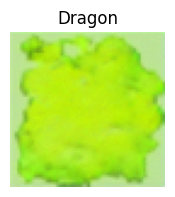

127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 853ms/step - accuracy: 0.9528 - loss: 0.0599
Epoch 341/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9526 - loss: 0.0605
Epoch 342/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9531 - loss: 0.0596
Epoch 343/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9514 - loss: 0.0620
Epoch 344/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9526 - loss: 0.0602
Epoch 345/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9535 - loss: 0.0590
Epoch 346/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9520 - loss: 0.0612
Epoch 347/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9530 - loss: 0.0597
Epoch 348/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9517 - loss: 0.0619
Epoch 349/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9541 - loss: 0.0575
Epoch 350/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9529 - loss: 0.0603
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:27<00:00, 11.49it/s]


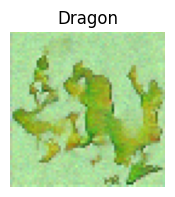

127/127 ━━━━━━━━━━━━━━━━━━━━ 107s 848ms/step - accuracy: 0.9523 - loss: 0.0608
Epoch 361/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9529 - loss: 0.0596
Epoch 362/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9528 - loss: 0.0602
Epoch 363/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9543 - loss: 0.0580
Epoch 364/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9535 - loss: 0.0588
Epoch 365/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9532 - loss: 0.0597
Epoch 366/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9534 - loss: 0.0594
Epoch 367/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9532 - loss: 0.0593
Epoch 368/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9527 - loss: 0.0599
Epoch 369/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9525 - loss: 0.0603
Epoch 370/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9520 - loss: 0.0618
E

Sampling sprite...: 100%|██████████| 1000/1000 [01:27<00:00, 11.42it/s]


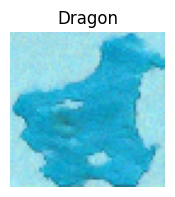

127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 853ms/step - accuracy: 0.9536 - loss: 0.0592
Epoch 381/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9540 - loss: 0.0581
Epoch 382/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9531 - loss: 0.0602
Epoch 383/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9519 - loss: 0.0611
Epoch 384/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.9535 - loss: 0.0598
Epoch 385/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9533 - loss: 0.0591
Epoch 386/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9535 - loss: 0.0591
Epoch 387/500
 22/127 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.9550 - loss: 0.0581

In [6]:
model.fit(
    poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20, "Dragon")]
)

In [ ]:
# Sample some sprites
# =====================================================================
model.plot_samples(6)

In [ ]:
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

## 2.2. Results and save model

In [ ]:
# Sample some sprites
# =====================================================================
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6, "Fire")
model.plot_samples(6, "Water")
model.plot_samples(6, "Grass")
model.plot_samples(6, "Dragon")

In [ ]:
# Save the model
# =====================================================================
# model.save(f"{MODELS_PATH}/diffusion_model") TODO: TBC

[BACK TO TOP](#top)